In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pandas as pd
from scipy.integrate import quad
from optimalEstimation import *

In [2]:
timelist = np.load('/home/penny/works/psd/inputs/radar_timelist.npy')
#32速度（m/s）
D = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,
              1.1875,1.375,1.625,1.875,2.125,2.375,2.75,3.25,3.75,4.25,4.75,5.5,
              6.5,7.5,8.5,9.5,11,13,15,17,19,21.5,24.5])
#32直径（mm）
V = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.1,1.3,1.5,1.7,
              1.9,2.2,2.6,3,3.4,3.8,4.4,5.2,6,6.8,7.6,8.8,10.4,12,13.6,15.2,
              17.6,20.8])

D[8:24] = (1.075 - 0.075*D[8:24])*D[8:24]
D[24:] = D[24:]*0.7

#采样面积不固定的
A = np.zeros((32,1),dtype='float')
#32直径通道间隔
deltaD = np.zeros((32,1),dtype='float')
#通道间隔（mm）
deltaD[0]=D[1]-D[0]
for i in range(1,32):
    deltaD[i]=D[i]-D[i-1]
#采样面积  m**2 
for i in range(32):
     A[i,0] = 0.18*(0.03-(0.5*D[i]/1000))
#month_list = ['01','03','05','07','08','10','12']

In [3]:
delta_h = 1+3.68*10**-5*3465 + 1.71*10**-9*3465**2
Vt = delta_h*(9.65-10.3/(np.exp(0.6*D)))
bac_list = np.load('./inputs/bac_list_32_mie_cla_2.npy')

In [4]:
t_grid = np.arange(2,32,1)
bac_list_t = np.load('./inputs/bac_list_32_mie_cla_2_t.npy')
ext_list_t = np.load('./inputs/ext_list_32_mie_cla_2_t.npy')

In [5]:
def cal_Z_Vr_from_psd(xx):

    #N0_1 = inv_boxcox(xx[0], lambda_value_N0)
    N0_1 = xx[0]
    #Dm = xx[1]
    Dm = inv_boxcox(xx[1], lambda_value_sigma)

    #t_grid_idx = argclosest(t_210,t_grid)
    #bac_list = bac_list_t[t_grid_idx]  
    
    Z = 0
    upper = 0
    under = 0
    data = pow(10,N0_1)*np.exp(-4*D/Dm)
    
    for iii in range(len(D)):
        Z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0])
        upper += data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0]*Vt[iii]
        under += data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0]
                
    Z = (8.62**4)/(math.pi**5 * 0.88)*Z
    Z = 10*math.log10(Z)
    V_sim = (upper/under)
 
    data = [Z,V_sim]
    
    to_return = pd.Series(data,index = ['Z','Vt'])
    return to_return

In [6]:
def get_colors_from_map(color_num, map="Spectral"):
    cmap = plt.get_cmap(map)  # 获取内置colormap
    return cmap(np.linspace(0, 1, color_num))

In [7]:
from scipy import stats
N0     = np.load('./results/3N0_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
N0 = np.array([math.log10(x) for x in N0])
N0 = np.array(N0, dtype = np.float64)
sigma  = np.load('./results/3sigma_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)
Z_list = np.load('./results/3Z_raindrop_disdrometer_2021to2023_hongyuan.npy',allow_pickle=True)

In [8]:
Z_list = np.array(Z_list, dtype = np.float64)
#transformed_N0, lambda_value_N0 = stats.boxcox(N0)
transformed_sigma, lambda_value_sigma = stats.boxcox(sigma)

In [9]:
def inv_boxcox(y, lambda_value):
    if lambda_value == 0:
        return np.exp(y)
    else:
        return (y * lambda_value + 1) ** (1 / lambda_value)

In [10]:
import seaborn as sns

## Retrieval

In [11]:
lenth = np.where((N0>=2) & (N0<=3))[0].shape[0]

In [12]:
def stratified_sample_miu(df, stratify_col, sample_sizes):
    samples = []  # 用于存放抽样结果的列表
    for category, size in sample_sizes.items():
        category_sample = df[df[stratify_col] == category].sample(size)  # 从类别中抽样
        samples.append(category_sample)  # 将抽样结果添加到列表中
    return pd.concat(samples)  # 返回合并后的样本

# 指定分层变量和样本大小
sample_sizes = {
    '_-2' :500,
    '-2_0': 500,
    '0_2': 500,
    '2_4': 500,
    '4_6': 500,
    '_8':200
}
#min_num = len(np.where(miu[idx_list[2]]<-2)[0])

data_cat = []
for x in sigma:
    if x < 0.5:
        data_cat.append('_-2')
    if (x>=0.5) and (x<1):
        data_cat.append('-2_0')
    if (x>=1) and (x<1.5):
        data_cat.append('0_2')
    if (x>=1.5) and (x<2):
        data_cat.append('2_4')
    if (x>=2) and (x<3):
        data_cat.append('4_6')
    if (x>=3):
        data_cat.append('_8')

# 创建一个示例数据集
data = {
    'Category': data_cat,
    'Value': list(sigma)
}
df = pd.DataFrame(data)  # 转换为DataFrame格式

sampled_miu = stratified_sample_miu(df, 'Category', sample_sizes)
sam_idx_miu = sampled_miu.index

In [13]:
def stratified_sample_sa(df, stratify_col, sample_sizes):
    samples = []  # 用于存放抽样结果的列表
    for category, size in sample_sizes.items():
        category_sample = df[df[stratify_col] == category].sample(size)  # 从类别中抽样
        samples.append(category_sample)  # 将抽样结果添加到列表中
    return pd.concat(samples)  # 返回合并后的样本

# 指定分层变量和样本大小
sample_sizes = {
    '_-2' :lenth,
    '-2_0': lenth,
    '0_2': lenth,
    '2_4': lenth,
    '4_6': lenth,
    '6_8': lenth,
    '_8':lenth
}
#min_num = len(np.where(miu[idx_list[2]]<-2)[0])

data_cat = []
for x in N0:
    if x < 2:
        data_cat.append('_-2')
    if (x>=2) and (x<3):
        data_cat.append('-2_0')
    if (x>=3) and (x<3.5):
        data_cat.append('0_2')
    if (x>=3.5) and (x<4):
        data_cat.append('2_4')
    if (x>=4) and (x<4.5):
        data_cat.append('4_6')
    if (x>=4.5)and (x<5):
        data_cat.append('6_8')
    if (x>=5):
        data_cat.append('_8')

# 创建一个示例数据集
data = {
    'Category': data_cat,
    'Value': list(N0)
}
df = pd.DataFrame(data)  # 转换为DataFrame格式

sampled_sa = stratified_sample_sa(df, 'Category', sample_sizes)
sam_idx_sa = sampled_sa.index

In [14]:
sam_idx_sa

Index([ 56326,  77805,  98321,  60741,  19293,  56332,  33426,   1710,   1828,
        66108,
       ...
        99166,  99163,   5179,  99156,   1058,  99063, 102356,  29936,  64669,
        77676],
      dtype='int64', length=6680)

In [15]:
sampled_sa = np.vstack((sampled_sa,sampled_miu))

In [16]:
sam_idx_sa = np.unique(sam_idx_sa)

#### 1. Read Data 地面验证5891例

In [19]:
N0_f = np.load('./results/wok05/2024_summer_surface_n0_1.npy')
N0_f = np.array([math.log10(x) for x in N0_f])
dm_f = np.load('./results/wok05/2024_summer_surface_dm_1.npy')
ts_f = np.load('./results/wok05/2024_summer_surface_tm_1.npy')
psd_i_v = np.load('./results/wok05/2024_summer_surface_vt_1.npy')
psd_i_z = np.load('./results/wok05/2024_summer_surface_ze_1.npy')

In [20]:
def argclosest(array, value, retvalue=False):
    """Returns the index of the closest value in array.  """
    idx = np.abs(array - value).argmin()

    return (idx, array[idx]) if retvalue else idx

#### 2. retrieve surface parameters

In [31]:
z_list = np.load('./results/wok05/2024_summer_surface_ze_1_profiles.npy')
l_list = np.load('./results/wok05/2024_summer_surface_ld_1_profiles.npy')

In [36]:
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
import matplotlib.colors as mcolors
dbz_levels = np.arange(-45, 45, 90/18)  # 14个区间
dbz_levels = [int(x) for x in dbz_levels]
ldr_levels = np.arange(-40, 14, 54/18)  # 14个区间
ldr_levels = [int(x) for x in ldr_levels]
rwd_levels = np.arange(  0,  4,  4/18)  # 14个区间
rwd_levels = [round(x,1) for x in rwd_levels]
rrv_levels = np.arange(-15, 15, 30/18)  # 14个区间
rrv_levels = [int(x) for x in rrv_levels]

# Create the color table found on NWS pages. # 14个区间
dbz_rgb = np.array([#[4,233,231],
                    [255,255,255],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198],[123,39,164],[96,4,194]], np.float32) / 255.0

#是一个辅助函数，可以帮助创建cmap和norm实例，其行为类似于Contourf的level和colors参数的行为
clrmap=mcolors.LinearSegmentedColormap.from_list("mycmap",dbz_rgb)

In [37]:
date_list =['20240601', '20240602', '20240603', '20240604', '20240605',
       '20240606', '20240607', '20240608', '20240609', '20240610',
       '20240611', '20240612', '20240613', '20240614', '20240615',
       '20240616', '20240617', '20240618', '20240619', '20240620',
       '20240621', '20240622', '20240623', '20240624', '20240625',
       '20240626', '20240627', '20240628', '20240629', '20240630',
       '20240701', '20240702', '20240703', '20240704', '20240705',
       '20240706', '20240707', '20240708', '20240709', '20240710',
       '20240711', '20240712', '20240713', '20240714', '20240715',
       '20240716', '20240717', '20240718', '20240719', '20240720',
       '20240721', '20240722', '20240723', '20240724', '20240725',
       '20240726', '20240727', '20240728', '20240729', '20240730',
       '20240731', '20240801', '20240802', '20240803', '20240804',
       '20240805', '20240806', '20240807', '20240808', '20240809',
       '20240810', '20240811', '20240812', '20240813', '20240814',
       '20240815', '20240816', '20240817', '20240818', '20240820',
       '20240821', '20240822', '20240823', '20240824', '20240825',
       '20240826', '20240827', '20240828', '20240829', '20240830',
       '20240831']
date_list = np.array(date_list)
timelist = np.load('./radar_timelist.npy')

In [ ]:
r_list= np.load('./results/wok05/2024_summer_surface_RR_1.npy')

In [13]:
xiaoyu_30_idx = []
dayu_30_idxxx = [] 

In [ ]:
for i in range(z_list_p.shape[0]):
    a = z_list_p[i][np.where(np.isnan(z_list_p[i]) == False)].max()
    if a>=30:
        dayu_30_idxxx.append(i)
        print(a)
    else:
        xiaoyu_30_idx.append(i)
        #print(a,"xiaoyu")

In [10]:
# 5891例 --> 3445例廓线
v_list_p = abs(np.load('./results/wok05/2024_summer_surface_vt_2_profiles.npy'))
z_list_p = np.load('./results/wok05/2024_summer_surface_ze_2_profiles.npy')
t_list_p = np.load('./results/wok05/2024_summer_surface_tm_2_profiles.npy')
top_idx = np.load('./results/wok05/2024_summer_surface_ti_2_profiles.npy')

In [16]:
    ticks_size = 19
    label_size = 19
    colorbar_ticks_size = 18
    colorbar_label_size = 18

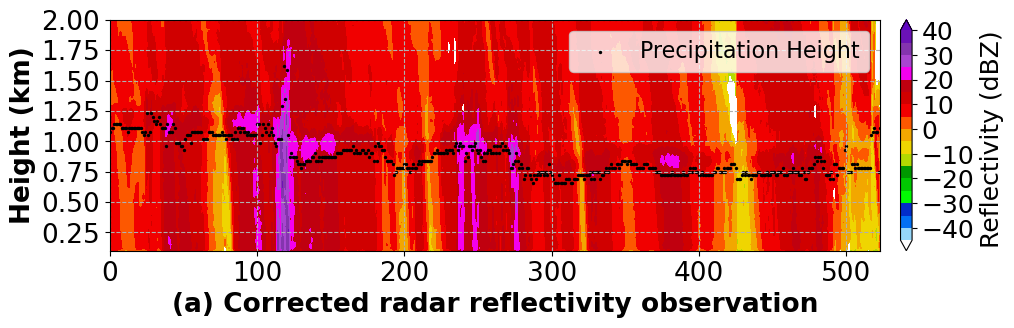

In [109]:
        x=np.arange(z_list_p[idx_this_kind,:].shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        c1=ax1.contourf(X,Y,z_list_p[idx_this_kind,:].T,cmap=clrmap, levels = dbz_levels,extend = 'both')
        plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 2, c = 'k',label = 'Precipitation Height') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.1,2) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.legend(fontsize = 16)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(a) Corrected radar reflectivity observation',size = label_size,fontweight='bold')
        ax1.set_ylabel('Height (km)',size = label_size,fontweight='bold')
        cb = fig.colorbar(c1 ,pad = 0.022)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'Reflectivity (dBZ) ',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_Z.png',bbox_inches = 'tight')
        #xlable_list = [x[8:10]+':'+x[10:12] for x in t_list_p[idx_this_kind][::100]]
        #ax1.set_xticks(range(0,len(idx_this_kind),100), xlable_list,size = ticks_size) #设置x轴显示的数值

In [194]:
y = np.arange(669)*0.03

In [51]:
def do_retrieval(inputs):
    #print( np.array([z_list_p.T[6,i],v_list_p.T[6,i]]),'------')
    oe_ref = optimalEstimation(
            x_vars = x_vars, # state variable names 要反演的量的名称
            x_a = x_a,  # a priori 均值 初猜场
            S_a = S_a, # a priori uncertainty 协方差矩阵 先验信息 
            y_vars = y_vars,  # measurement variable names 测量通道 通道频率
            y_obs = inputs,   # observations 通道的观测
            #y_obs = cal_Z_Vr_from_psd(test[:,i])+np.random.uniform(-0.25, 0.25, 2),   # observations 通道的观测
            S_y = S_y,         # observation uncertainty 观测的不确定度 误差
            forward = cal_Z_Vr_from_psd, # forward Operator 计算正向模型的函数 返回亮温值
            #forwardKwArgs=forwardKwArgs, # additonal function arguments 
            x_lowerLimit = {'N0':0},
            x_upperLimit = {'N0':7},
            #x_truth=x_truth,
            useFactorInJac = False,
            perturbation = 1e-6,
            verbose = False,
            convergenceFactor = 2,
                                )
    oe_ref.doRetrieval(maxIter=500)  
    return oe_ref.x_op.values[0],oe_ref.x_op.values[1],oe_ref.x_op_err[0],oe_ref.x_op_err[1]

In [ ]:
retrieved_N0 = np.zeros((len(top_idx[idx_this_kind]),y.shape[0]))
retrieved_Dm = np.zeros((len(top_idx[idx_this_kind]),y.shape[0]))
N0_uncertain = np.zeros((len(top_idx[idx_this_kind]),y.shape[0]))
Dm_uncertain = np.zeros((len(top_idx[idx_this_kind]),y.shape[0]))
attenuationn = np.zeros((len(top_idx[idx_this_kind]),y.shape[0]))
for i in range(len(top_idx[idx_this_kind])):
    try:
        if (z_list_p[idx_this_kind,:].T[6,i] != np.nan) and ((v_list_p[idx_this_kind,:].T[6,i] != np.nan)):
            t_210 = 14
            t_grid_idx = argclosest(t_210,t_grid)
            bac_list = bac_list_t[t_grid_idx] 

            aa,bb,cc,dd = do_retrieval(np.array([z_list_p[idx_this_kind,:].T[6,i],v_list_p[idx_this_kind,:].T[6,i]]))
    
            retrieved_N0[i,6] = aa
            Dm_r = inv_boxcox(bb, lambda_value_sigma)
            retrieved_Dm[i,6] = Dm_r
    
            N0_uncertain[i,6] = cc
            Dm_uncertain[i,6] = dd

            # 衰减订正一下。。。
            data = pow(10,aa)*np.exp(-4*D/Dm_r)
            e = 0
            z = 0
            for iii in range(len(D)):
                z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0])
                e += (data[iii]*(0.25*math.pi*ext_list_t[t_grid_idx][iii])*D[iii]**2*deltaD[iii][0]) 
            attenuationn[i,6] = (10*np.log10(z/np.exp((-2*e*(10**-6)*30)))-10*np.log10(z)) 

            acc_e = []
            for zidx_in_prof in range(7,top_idx[idx_this_kind][i]):
                e = 0
                z = 0
                t_210 = 14-(0.18*(zidx_in_prof-7))
                t_grid_idx = argclosest(t_210,t_grid)
                bac_list = bac_list_t[t_grid_idx] 
                
                aa,bb,cc,dd = do_retrieval(np.array([z_list_p[idx_this_kind,:].T[zidx_in_prof,i]+attenuationn[i,zidx_in_prof-1],v_list_p[idx_this_kind,:].T[zidx_in_prof,i]]))
                
                retrieved_N0[i,zidx_in_prof] = aa
                Dm_r = inv_boxcox(bb, lambda_value_sigma)
                retrieved_Dm[i,zidx_in_prof] = Dm_r
        
                N0_uncertain[i,zidx_in_prof] = cc
                Dm_uncertain[i,zidx_in_prof] = dd
                
                for iii in range(len(D)):
                    z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0])
                    e += (data[iii]*(0.25*math.pi*ext_list_t[t_grid_idx][iii])*D[iii]**2*deltaD[iii][0]) 
                acc_e.append(e)
                #attenuationn[i,zidx_in_prof] = (10*np.log10(z/np.exp((-2*e*(10**-6)*30)))-10*np.log10(z)) 
                attenuationn[i,zidx_in_prof] = (10*np.log10(z/np.exp((-2*sum(acc_e)*(10**-6)*30)))-10*np.log10(z))
                               
    except:
        continue
        
np.save('/home/penny/works/psd/results/wok05/8_15_obs_retrieved_N0',retrieved_N0)
np.save('/home/penny/works/psd/results/wok05/8_15_obs_retrieved_Dm',retrieved_Dm)
np.save('/home/penny/works/psd/results/wok05/8_15_obs_N0_uncertain',N0_uncertain)
np.save('/home/penny/works/psd/results/wok05/8_15_obs_Dm_uncertain',Dm_uncertain)
np.save('/home/penny/works/psd/results/wok05/8_15_obs_attenuationn',attenuationn)

In [19]:
retrieved_N0 = np.load('/home/penny/works/psd/results/wok05/8_15_obs_retrieved_N0.npy')
retrieved_Dm = np.load('/home/penny/works/psd/results/wok05/8_15_obs_retrieved_Dm.npy')
N0_uncertain = np.load('/home/penny/works/psd/results/wok05/8_15_obs_N0_uncertain.npy')
Dm_uncertain = np.load('/home/penny/works/psd/results/wok05/8_15_obs_Dm_uncertain.npy')
attenuationn = np.load('/home/penny/works/psd/results/wok05/8_15_obs_attenuationn.npy')

In [160]:
rwd_levels = np.arange(  0,  2.5,  2.5/18)  # 14个区间
rwd_levels = [round(x,1) for x in rwd_levels]
rrv_levels = np.arange(-15, 15, 30/18)  # 14个区间
rrv_levels = [int(x) for x in rrv_levels]

# Create the color table found on NWS pages. # 14个区间
dbz_rgb = np.array([#[4,233,231],
                    [255,255,255],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198],[123,39,164],[96,4,194]], np.float32) / 255.0

#是一个辅助函数，可以帮助创建cmap和norm实例，其行为类似于Contourf的level和colors参数的行为
clrmap=mcolors.LinearSegmentedColormap.from_list("mycmap",dbz_rgb)

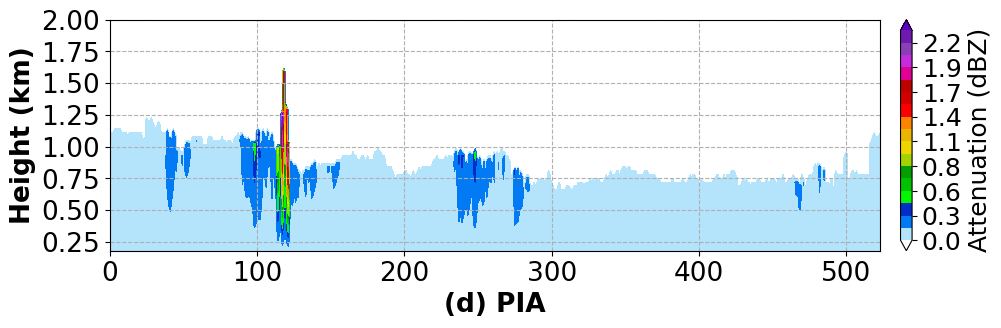

In [161]:
        x=np.arange(attenuationn.shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        c1=ax1.contourf(X,Y,attenuationn.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        #plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 1, c = 'k',label = 'Melting layer') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.18,2) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(d) PIA',size = label_size,fontweight='bold')
        ax1.set_ylabel('Height (km)',size = label_size,fontweight='bold')
        cb = fig.colorbar(c1 ,pad = 0.022)
        #cb.set_clim(0,2)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'Attenuation (dBZ) ',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_atten.png',bbox_inches = 'tight')
        #xlable_list = [x[8:10]+':'+x[10:12] for x in t_list_p[idx_this_kind][::100]]
        #ax1.set_xticks(range(0,len(idx_this_kind),100), xlable_list,size = ticks_size) #设置x轴显示的数值

In [114]:
rwd_levels = np.arange(  2,  8,  4/18)  # 14个区间
rwd_levels = [round(x,1) for x in rwd_levels]
rrv_levels = np.arange(-15, 15, 30/18)  # 14个区间
rrv_levels = [int(x) for x in rrv_levels]

# Create the color table found on NWS pages. # 14个区间
dbz_rgb = np.array([#[4,233,231],
                    [255,255,255],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198],[123,39,164],[96,4,194]], np.float32) / 255.0

#是一个辅助函数，可以帮助创建cmap和norm实例，其行为类似于Contourf的level和colors参数的行为
clrmap=mcolors.LinearSegmentedColormap.from_list("mycmap",dbz_rgb)

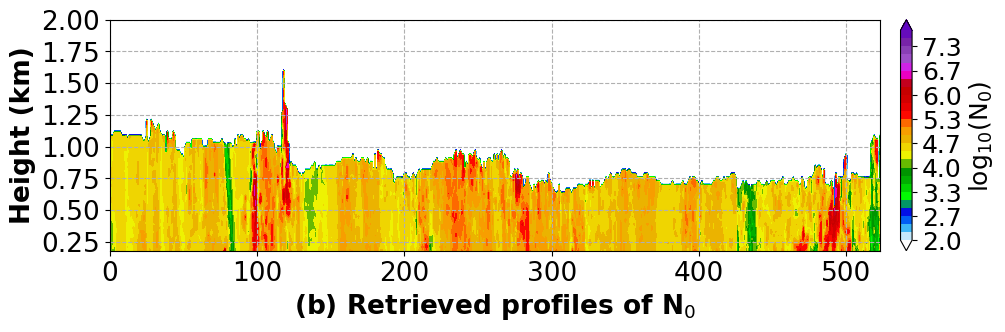

In [116]:
        x=np.arange(attenuationn.shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        c1=ax1.contourf(X,Y,retrieved_N0.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        #plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 1, c = 'k',label = 'Melting layer') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.18,2) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(b) Retrieved profiles of N$_0$',size = label_size,fontweight='bold')
        ax1.set_ylabel('Height (km)',size = label_size,fontweight='bold')
        cb = fig.colorbar(c1 ,pad = 0.022)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'log$_{10}$(N$_0$) ',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_N0.png',bbox_inches = 'tight')
        #xlable_list = [x[8:10]+':'+x[10:12] for x in t_list_p[idx_this_kind][::100]]
        #ax1.set_xticks(range(0,len(idx_this_kind),100), xlable_list,size = ticks_size) #设置x轴显示的数值

In [117]:
rwd_levels = np.arange(  0,  2,  1.8/18)  # 14个区间
rwd_levels = [round(x,1) for x in rwd_levels]
rrv_levels = np.arange(-15, 15, 30/18)  # 14个区间
rrv_levels = [int(x) for x in rrv_levels]

# Create the color table found on NWS pages. # 14个区间
dbz_rgb = np.array([#[4,233,231],
                    [255,255,255],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198],[123,39,164],[96,4,194]], np.float32) / 255.0

#是一个辅助函数，可以帮助创建cmap和norm实例，其行为类似于Contourf的level和colors参数的行为
clrmap=mcolors.LinearSegmentedColormap.from_list("mycmap",dbz_rgb)

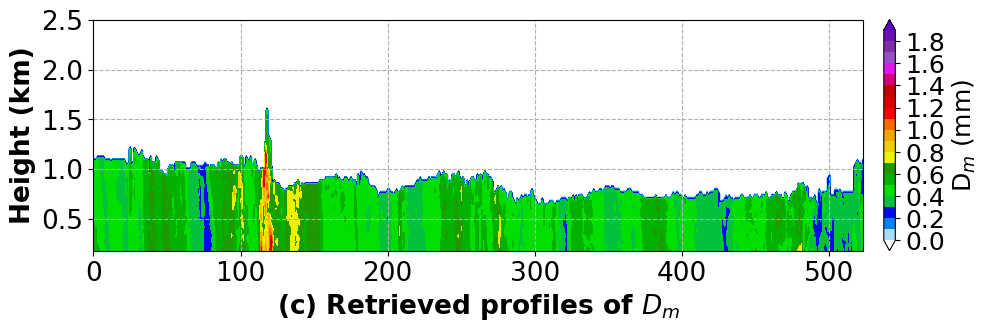

In [119]:
        x=np.arange(attenuationn.shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        #c1=ax1.contourf(X,Y,retrieved_Dm.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        c1=ax1.contourf(X,Y,retrieved_Dm.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        #plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 1, c = 'k',label = 'Melting layer') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.18,2.5) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(c) Retrieved profiles of $D_m$',size = label_size,fontweight='bold')
        ax1.set_ylabel('Height (km)',size = label_size,fontweight='bold')
        cb = fig.colorbar(c1 ,pad = 0.022)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'D$_m$ (mm)',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_dM.png',bbox_inches = 'tight')

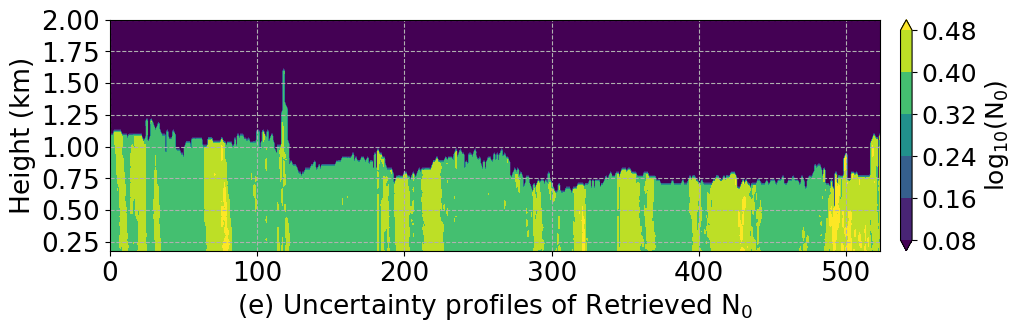

In [59]:
        x=np.arange(attenuationn.shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        #c1=ax1.contourf(X,Y,retrieved_Dm.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        c1=ax1.contourf(X,Y,N0_uncertain.T,extend = 'both')
        #plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 1, c = 'k',label = 'Melting layer') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.18,2) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(e) Uncertainty profiles of Retrieved N$_0$',size = label_size)
        ax1.set_ylabel('Height (km)',size = label_size)
        cb = fig.colorbar(c1 ,pad = 0.022)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'log$_{10}$(N$_0$)',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_N0_un.png',bbox_inches = 'tight')

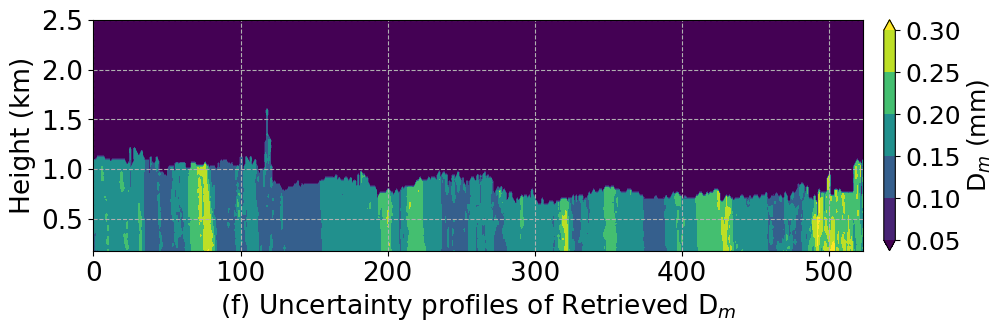

In [60]:
        x=np.arange(attenuationn.shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        #c1=ax1.contourf(X,Y,retrieved_Dm.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        c1=ax1.contourf(X,Y,Dm_uncertain.T,extend = 'both')
        #plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 1, c = 'k',label = 'Melting layer') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.18,2.5) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(f) Uncertainty profiles of Retrieved D$_m$',size = label_size)
        ax1.set_ylabel('Height (km)',size = label_size)
        cb = fig.colorbar(c1 ,pad = 0.022)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'D$_m$ (mm)',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_dM_un.png',bbox_inches = 'tight')

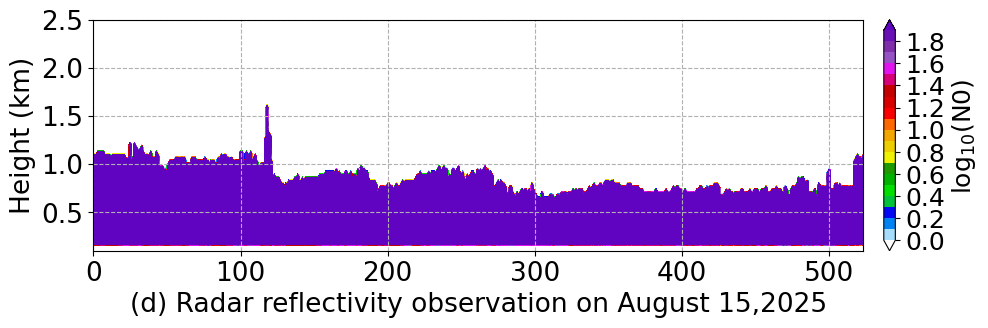

In [61]:
        x=np.arange(attenuationn.shape[0])
        y=np.arange(669)*0.03 #高度
        X, Y = np.meshgrid(x, y)
        fig = plt.figure(figsize=(12, 3))
        ax1=fig.add_subplot(111)
        c1=ax1.contourf(X,Y,retrieved_N0.T,cmap=clrmap, levels = rwd_levels,extend = 'both')
        #plt.scatter(range(len(idx_this_kind)),top_idx[idx_this_kind]*0.03, s = 1, c = 'k',label = 'Melting layer') # 这里是[8:],所以后面是height_r)+7
        #plt.savefig('/home/penny/works/psd/results/wok05/Pricip_melting_layer/20240708_Z.png',bbox_inches = 'tight')
        ax1.set_ylim(0.1,2.5) #设置x轴的范围
        plt.yticks(size = ticks_size)
        plt.xticks(size = ticks_size)
        plt.grid(True,linestyle = '--')
        ax1.set_xlabel('(d) Radar reflectivity observation on August 15,2025',size = label_size)
        ax1.set_ylabel('Height (km)',size = label_size)
        cb = fig.colorbar(c1 ,pad = 0.022)
        cb.ax.tick_params(labelsize=colorbar_ticks_size)
        cb.set_label(label = 'log$_{10}$(N0) ',fontsize = colorbar_label_size)
        plt.savefig('/home/penny/works/psd/results/wok05/8_15_obs_N0.png',bbox_inches = 'tight')
        #xlable_list = [x[8:10]+':'+x[10:12] for x in t_list_p[idx_this_kind][::100]]
        #ax1.set_xticks(range(0,len(idx_this_kind),100), xlable_list,size = ticks_size) #设置x轴显示的数值

In [ ]:
retrieved_N0 = np.zeros((len(top_idx),y.shape[0]))
retrieved_Dm = np.zeros((len(top_idx),y.shape[0]))
N0_uncertain = np.zeros((len(top_idx),y.shape[0]))
Dm_uncertain = np.zeros((len(top_idx),y.shape[0]))
attenuationn = np.zeros((len(top_idx),y.shape[0]))
for i in range(len(top_idx)):
    try:
        if (z_list_p.T[6,i] != np.nan) and ((v_list_p.T[6,i] != np.nan)):
            t_210 = 14
            t_grid_idx = argclosest(t_210,t_grid)
            bac_list = bac_list_t[t_grid_idx] 

            aa,bb,cc,dd = do_retrieval(np.array([z_list_p.T[6,i],v_list_p.T[6,i]]))
    
            retrieved_N0[i,6] = aa
            Dm_r = inv_boxcox(bb, lambda_value_sigma)
            retrieved_Dm[i,6] = Dm_r
    
            N0_uncertain[i,6] = cc
            Dm_uncertain[i,6] = dd

            # 衰减订正一下。。。
            data = pow(10,aa)*np.exp(-4*D/Dm_r)
            e = 0
            z = 0
            for iii in range(len(D)):
                z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0])
                e += (data[iii]*(0.25*math.pi*ext_list_t[t_grid_idx][iii])*D[iii]**2*deltaD[iii][0]) 
            attenuationn[i,6] = (10*np.log10(z/np.exp((-2*e*(10**-6)*30)))-10*np.log10(z)) 

            acc_e = []
            for zidx_in_prof in range(7,top_idx[i]):
                e = 0
                z = 0
                t_210 = 14-(0.18*(zidx_in_prof-7))
                t_grid_idx = argclosest(t_210,t_grid)
                bac_list = bac_list_t[t_grid_idx] 
                
                aa,bb,cc,dd = do_retrieval(np.array([z_list_p.T[zidx_in_prof,i]+attenuationn[i,zidx_in_prof-1],v_list_p.T[zidx_in_prof,i]]))
                
                retrieved_N0[i,zidx_in_prof] = aa
                Dm_r = inv_boxcox(bb, lambda_value_sigma)
                retrieved_Dm[i,zidx_in_prof] = Dm_r
        
                N0_uncertain[i,zidx_in_prof] = cc
                Dm_uncertain[i,zidx_in_prof] = dd
                
                for iii in range(len(D)):
                    z += (data[iii]*(0.25*math.pi*bac_list[iii])*D[iii]**2*deltaD[iii][0])
                    e += (data[iii]*(0.25*math.pi*ext_list_t[t_grid_idx][iii])*D[iii]**2*deltaD[iii][0]) 
                acc_e.append(e)
                #attenuationn[i,zidx_in_prof] = (10*np.log10(z/np.exp((-2*e*(10**-6)*30)))-10*np.log10(z)) 
                attenuationn[i,zidx_in_prof] = (10*np.log10(z/np.exp((-2*sum(acc_e)*(10**-6)*30)))-10*np.log10(z))
                               
    except:
        continue
        
np.save('/home/penny/works/psd/results/wok05/2024_7_8_obs_retrieved_N0',retrieved_N0)
np.save('/home/penny/works/psd/results/wok05/2024_7_8_obs_retrieved_Dm',retrieved_Dm)
np.save('/home/penny/works/psd/results/wok05/2024_7_8_obs_N0_uncertain',N0_uncertain)
np.save('/home/penny/works/psd/results/wok05/2024_7_8_obs_Dm_uncertain',Dm_uncertain)
np.save('/home/penny/works/psd/results/wok05/2024_7_8_obs_attenuationn',attenuationn)

# 雨滴谱空间分布特征

In [7]:
retrieved_N0 = np.load('/home/penny/works/psd/results/wok05/2024_7_8_obs_retrieved_N0.npy')
retrieved_Dm = np.load('/home/penny/works/psd/results/wok05/2024_7_8_obs_retrieved_Dm.npy')
N0_uncertain = np.load('/home/penny/works/psd/results/wok05/2024_7_8_obs_N0_uncertain.npy')
Dm_uncertain = np.load('/home/penny/works/psd/results/wok05/2024_7_8_obs_Dm_uncertain.npy')
attenuationn = np.load('/home/penny/works/psd/results/wok05/2024_7_8_obs_attenuationn.npy')

In [ ]:
z_list_p.shape

In [ ]:
xx = pow(10,z_list_p.reshape(-1)/10)
yy = attenuationn.reshape(-1)

In [83]:
def fit_and_find_coef(x1,y1):
    # Transform data for linear fitting: log(yy) = log(a) + b * log(xx)
    log_xx = np.log(x1)
    log_yy = np.log(y1)
    # Perform linear regression on the transformed data
    slope, intercept = np.polyfit(log_xx, log_yy, 1)
    print(slope,intercept)
    
    # Extract refined parameters
    a_refined = np.exp(intercept)  # Since log(a) = intercept
    b_refined = slope  # Since b is the slope

    return a_refined, b_refined

In [ ]:
D_idx = []
N_idx = []
for i in range(len(t_list_p)):
    tii = int(t_list_p[i][8:10])
    if (tii >= 6) and (tii < 21):
        D_idx.append(i)
    else:
        N_idx.append(i)

In [81]:
from scipy.stats import gaussian_kde

In [150]:
xx = pow(10,z_list_p[:,9]/10)
yy = attenuationn[:,9]
id_s = np.where((yy != 0) & (np.log(yy)!=0))[0]
ID_S = np.where(np.log(xx[id_s]) != 0)
id_s = np.intersect1d(id_s,ID_S)
#id_d = np.intersect1d(id_s,np.array(D_idx))

xx = pow(10,z_list_p[:,9]/10)[id_s]
yy = attenuationn[:,9][id_s]
xy = np.vstack([xx, yy])
z = gaussian_kde(xy)(xy)
a_refined,b_refined = fit_and_find_coef(xx,yy)

/tmp/ipykernel_3602/841696577.py:3: RuntimeWarning: divide by zero encountered in log
  id_s = np.where((yy != 0) & (np.log(yy)!=0))[0]


0.6806630754901706 -6.917979915640208


In [140]:
xx = pow(10,z_list_p[:,9]/10)
yy = attenuationn[:,9]

id_s = np.where((yy != 0) & (np.log(yy)!=0))[0]
ID_S = np.where(np.log(xx[id_s]) != 0)
id_s = np.intersect1d(id_s,ID_S)
id_n = np.intersect1d(id_s,np.array(N_idx))

xx_n = pow(10,z_list_p[:,9]/10)[id_n]
yy_n = attenuationn[:,9][id_n]

a_refined_n,b_refined_n = fit_and_find_coef(xx_n,yy_n)

0.6730849251644437 -6.8536133653258355


/tmp/ipykernel_3602/2714393046.py:4: RuntimeWarning: divide by zero encountered in log
  id_s = np.where((yy != 0) & (np.log(yy)!=0))[0]


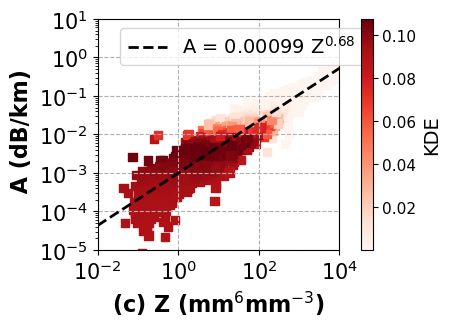

In [227]:
f  = plt.figure(figsize = (4,3))
ax = f.add_subplot()
plt.scatter(xx,yy,c = z,marker = 's',cmap = 'Reds',alpha = 1)
#plt.scatter(xx_n,yy_n,marker = 's',c = '#d89090',alpha = 0.7,label = 'Night')
plt.plot(np.arange(0.01,10000,10), (a_refined)*np.arange(0.01,10000,10)**b_refined,linestyle = '--',linewidth = 2,c = 'k',label = 'A = '+str(round(a_refined,6))+' Z$^{'+str(round(b_refined,2))+'}$')
#plt.plot(np.arange(0.1,10000,10), (a_refined_n)*np.arange(0.1,10000,10)**b_refined_n,linestyle = '--',linewidth = 2,c = 'Crimson',label = 'Atten = '+str(round(a_refined,5))+' Z$^{'+str(round(b_refined,2))+'}$')
ax.set_yscale("log")
ax.set_xscale("log")
plt.xlim(0.01,10000)
plt.ylim(0.00001,10)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.grid(True,linestyle = '--')
cb = plt.colorbar(pad = 0.07)
cb.set_label(label = 'KDE', fontsize = 14)
plt.legend(fontsize = 14, loc='lower right', bbox_to_anchor = (1.1, 0.8), borderaxespad = 0)
plt.ylabel(' A (dB/km)',size  =16,fontweight='bold')
plt.xlabel('(c) Z (mm$^6$mm$^{-3}$)',size = 16,fontweight='bold')
cb.ax.tick_params(labelsize=11)
plt.savefig('/home/penny/works/psd/results/wok05/2024_Z_A_relation.png',bbox_inches = 'tight')

In [243]:
xx = retrieved_Dm[:,9]
yy = attenuationn[:,9]/pow(10,z_list_p[:,9]/10)
id_s = np.where((yy != 0) & (np.log(yy)!=0))[0]
ID_S = np.where(np.log(xx[id_s]) != 0)
id_s = np.intersect1d(id_s,ID_S)
#id_d = np.intersect1d(id_s,np.array(D_idx))

xx = retrieved_Dm[:,9][id_s]
yy = (attenuationn[:,9]/pow(10,z_list_p[:,9]/10))[id_s]
xy = np.vstack([xx, yy])
z = gaussian_kde(xy)(xy)
a_refined,b_refined = fit_and_find_coef(xx,yy)

/tmp/ipykernel_3602/1156080203.py:3: RuntimeWarning: divide by zero encountered in log
  id_s = np.where((yy != 0) & (np.log(yy)!=0))[0]


-1.9153722390490993 -8.919696669000174


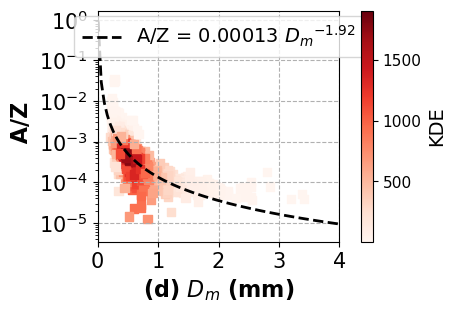

In [260]:
f  = plt.figure(figsize = (4,3))
ax = f.add_subplot()
plt.scatter(xx,yy,c = z,marker = 's',cmap = 'Reds',alpha = 1)
#plt.scatter(xx_n,yy_n,marker = 's',c = '#d89090',alpha = 0.7,label = 'Night')
plt.plot(np.arange(0.01,5,0.05), (a_refined)*np.arange(0.01,5,0.05)**b_refined,linestyle = '--',linewidth = 2,c = 'k',label = 'A/Z = '+str(round(a_refined,5))+' $D_m$$^{'+str(round(b_refined,2))+'}$')
#plt.plot(np.arange(0.1,10000,10), (a_refined_n)*np.arange(0.1,10000,10)**b_refined_n,linestyle = '--',linewidth = 2,c = 'Crimson',label = 'Atten = '+str(round(a_refined,5))+' Z$^{'+str(round(b_refined,2))+'}$')
ax.set_yscale("log")
#ax.set_xscale("log")
plt.xlim(0,4)
#plt.ylim(0.00001,10)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.grid(True,linestyle = '--')
cb = plt.colorbar(pad = 0.07)
cb.set_label(label = 'KDE', fontsize = 14)
#plt.clim(200,1500)
plt.legend(fontsize = 14, loc='lower right', bbox_to_anchor = (1.1, 0.8), borderaxespad = 0)
plt.ylabel(' A/Z',size  =16,fontweight='bold')
plt.xlabel('(d) $D_m$ (mm)',size = 16,fontweight='bold')
cb.ax.tick_params(labelsize=11)
plt.savefig('/home/penny/works/psd/results/wok05/2024_Dm_A_relation.png',bbox_inches = 'tight')

In [17]:
y=np.arange(669)*0.03 #高度

In [122]:
    df = pd.DataFrame(retrieved_N0[dayu_30_idxxx,6:80])
    af = pd.DataFrame(retrieved_N0[xiaoyu_30_idx,6:80])

<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:41: SyntaxWarning: invalid escape sequence '\g'
<>:19: SyntaxWarning: invalid escape sequence '\g'
<>:41: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_15054/3880873869.py:19: SyntaxWarning: invalid escape sequence '\g'
  axs.plot(df[df!=0].mean(axis = 0)[::4], y_positions, linestyle = '--', alpha = 0.8, color='crimson', lw=2,label = 'Z$\geq$30 dBZ')
/tmp/ipykernel_15054/3880873869.py:41: SyntaxWarning: invalid escape sequence '\g'
  '''
/tmp/ipykernel_15054/3880873869.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(range(2,7),size = 14)


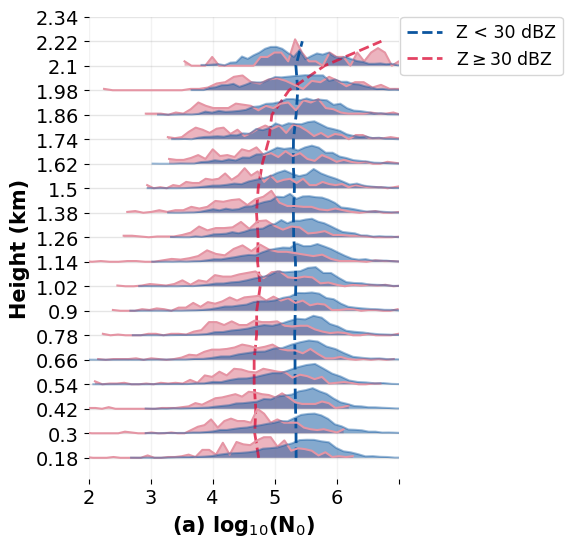

In [64]:
    # 分开画
    df = pd.DataFrame(retrieved_N0[dayu_30_idxxx,6:80])
    af = pd.DataFrame(retrieved_N0[xiaoyu_30_idx,6:80])
    y_names = [str(round(x,2)) for x in y[6:80]]
    df.columns = y_names
    af.columns = y_names
    #colors = get_colors_from_map(len(range(6,90)[::4]), "Spectral")
 
    x = list(range(6,80)[::4])
 
    # Y轴位置
    y_positions = [i*1 for i in range(len(x))]
    y_positions_name = y_names[::4]
 
    # 创建图形
    fig, axs = plt.subplots(figsize=(4, 6))
    
    axs.plot(af[af!=0].mean(axis = 0)[::4], y_positions, linestyle = '--',  color='#0B559f', lw=2 ,label = 'Z < 30 dBZ')
    axs.plot(df[df!=0].mean(axis = 0)[::4], y_positions, linestyle = '--', alpha = 0.8, color='crimson', lw=2,label = 'Z$\geq$30 dBZ')
 
    # 为每个月绘制核密度曲线，并水平错开显示
    for i, month in enumerate(x[:-2]):
        # 核密度估计
        filtered_data = df[y_positions_name[i]][df[y_positions_name[i]] != 0]
        density, bins = np.histogram(filtered_data, bins=40, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#E595A4', alpha=0.7)
        axs.plot(bins, y_positions[i] + density, color='#E595A4', lw=1.5, alpha=1)

        # 核密度估计
        filtered_data = af[y_positions_name[i]][af[y_positions_name[i]] != 0]
        density, bins = np.histogram(filtered_data, bins=40, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#0B559f', alpha=0.5)
        axs.plot(bins, y_positions[i] + density,color='#0B559f', lw=1.5, alpha=0.4)

    # 为每个月绘制核密度曲线，并水平错开显示\
    '''
    for i, month in enumerate(x[-2:-1]):
        # 核密度估计
        filtered_data = df['2.22'][df['2.22'] != 0]
        density, bins = np.histogram(filtered_data, bins=40, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        #print(y_positions[i] + density, df[y_names[month]])
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#E595A4', alpha=0.7,label = 'Z$\geq$30 dBZ')
        axs.plot(bins, y_positions[i] + density, color='#E595A4', lw=1.5, alpha=1)

        # 核密度估计
        filtered_data = df['2.22'][df['2.22'] != 0]
        density, bins = np.histogram(filtered_data, bins=40, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        print(y_positions[i] + density)
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#0B559f', alpha=0.5,label = 'Z < 30 dBZ')
        axs.plot(bins, y_positions[i] + density, lw=1.5,color='#0B559f', alpha=0.4)
    '''

    # 设置月份作为Y轴标签
    axs.set_yticks(y_positions)
    axs.set_yticklabels(y_positions_name,size = 14)
    #axs.set_xticks(range(2,6))
    axs.set_xticklabels(range(2,7),size = 14)
 
    # 添加横轴的网格线
    axs.grid(axis='y', linewidth=1, color='gray', alpha=0.2)
    axs.grid(axis='x', linewidth=1, color='gray', alpha=0.1)
    
    axs.set_xlabel('(a) log$_{10}$(N$_0$)',size = 15,fontweight='bold')
    axs.set_ylabel('Height (km)',size = 15,fontweight='bold')
    # 去掉边框线
    axs.spines['top'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    plt.xlim(1,6)
    plt.legend(fontsize = 12.5, loc='upper right', bbox_to_anchor = (1.53, 1), borderaxespad = 0)
    #axs.set_yticks(y_names[:-2][::4])
 
    # 显示图像
    plt.savefig('/home/penny/works/psd/results/wok05/7_8_N0_vertical_distribution.png',bbox_inches = 'tight')

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:39: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:39: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_15054/2562331157.py:18: SyntaxWarning: invalid escape sequence '\g'
  axs.plot(df[df!=0].mean(axis = 0)[::4], y_positions, linestyle = '--', alpha = 0.8, color='crimson', lw=2,label = 'Z$\geq$30 dBZ')
/tmp/ipykernel_15054/2562331157.py:39: SyntaxWarning: invalid escape sequence '\g'
  '''


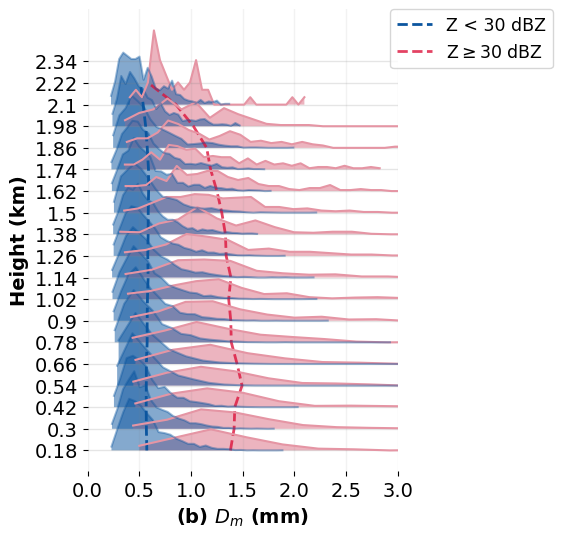

In [63]:
    df = pd.DataFrame(retrieved_Dm[dayu_30_idxxx,6:80])
    af = pd.DataFrame(retrieved_Dm[xiaoyu_30_idx,6:80])
    y_names = [str(round(x,2)) for x in y[6:80]]
    df.columns = y_names
    af.columns = y_names
    #colors = get_colors_from_map(len(range(6,90)[::4]), "Spectral")
 
    x = list(range(6,80)[::4])
 
    # Y轴位置
    y_positions = [i*1 for i in range(len(x))]
    y_positions_name = y_names[::4]
 
    # 创建图形
    fig, axs = plt.subplots(figsize=(4, 6))

    axs.plot(af[af!=0].mean(axis = 0)[::4], y_positions, linestyle = '--', color='#0B559f', lw=2 ,label = 'Z < 30 dBZ')
    axs.plot(df[df!=0].mean(axis = 0)[::4], y_positions, linestyle = '--', alpha = 0.8, color='crimson', lw=2,label = 'Z$\geq$30 dBZ')
 
    # 为每个月绘制核密度曲线，并水平错开显示
    for i, month in enumerate(x[:-2]):
        # 核密度估计
        filtered_data = df[y_positions_name[i]][df[y_positions_name[i]] != 0]
        density, bins = np.histogram(filtered_data, bins=30, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#E595A4', alpha=0.7)
        axs.plot(bins, y_positions[i] + density, color='#E595A4', lw=1.5, alpha=1)

        # 核密度估计
        filtered_data = af[y_positions_name[i]][af[y_positions_name[i]] != 0]
        density, bins = np.histogram(filtered_data, bins=30, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#0B559f', alpha=0.5)
        axs.plot(bins, y_positions[i] + density, color='#0B559f', lw=1.5, alpha=0.4)

    # 为每个月绘制核密度曲线，并水平错开显示
    '''
    for i, month in enumerate(x[-3:-2]):
        # 核密度估计
        filtered_data = df[y_names[month]][df[y_names[month]] != 0]
        density, bins = np.histogram(filtered_data, bins=50, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#E595A4', alpha=0.5,label = 'Z$\geq$30 dBZ')
        axs.plot(bins, y_positions[i] + density, color='#E595A4', lw=1.5, alpha=0.4)

        # 核密度估计
        filtered_data = af[y_names[month]][af[y_names[month]] != 0]
        density, bins = np.histogram(filtered_data, bins=50, density=True)
        bins = 0.5 * (bins[1:] + bins[:-1])  # 转换为 bin 的中心
        # 每个月份的曲线位置偏移
        axs.fill_between(bins, y_positions[i] + density, y_positions[i], facecolor='#0B559f', alpha=0.5,label = 'Z < 30 dBZ')
        axs.plot(bins, y_positions[i] + density, color='#0B559f', lw=1.5, alpha=1)
    '''
 
    # 设置月份作为Y轴标签
    axs.set_yticks(y_positions)
    axs.set_yticklabels(y_positions_name,size = 14)
    #axs.set_xticks(range(2,6))
    plt.xticks(size = 14)
 
    # 添加横轴的网格线
    axs.grid(axis='y', linewidth=1, color='gray', alpha=0.2)
    axs.grid(axis='x', linewidth=1, color='gray', alpha=0.1)
    
    axs.set_xlabel('(b) $D_m$ (mm)',size = 14,fontweight='bold')
    axs.set_ylabel('Height (km)',size = 14,fontweight='bold')
    # 去掉边框线
    axs.spines['top'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    plt.xlim(0,3)
    plt.legend(fontsize = 12.5, loc='upper right', bbox_to_anchor = (1.5, 1), borderaxespad = 0)
 
    # 显示图像
    plt.savefig('/home/penny/works/psd/results/wok05/7_8_Dm_vertical_distribution.png',bbox_inches = 'tight')


In [327]:
time_sel_idx = []
for i in range(24):
    a = []
    for ti_idx in range(len(t_list_p)):
        ti = t_list_p[ti_idx]
        if int(ti[-6:-4]) == i:
            a.append(ti_idx)
    time_sel_idx.append(a)
        

In [385]:
df = pd.DataFrame(np.zeros((t_list_p.shape[0]*3,3)), columns = ['data','leibie','Height'])
af = pd.DataFrame(np.zeros((t_list_p.shape[0]*3,2)), columns = ['data','leibie'])

In [386]:
data = []
data1 = []
data2 = []
time = []
for i in range(24):
    data += list(retrieved_N0[time_sel_idx[i],7])
    data1 += list(retrieved_N0[time_sel_idx[i],17])
    data2 += list(retrieved_N0[time_sel_idx[i],55])
    time += list(np.repeat(str(i),len(retrieved_N0[time_sel_idx[i]])))


height = list(np.repeat('210m',len(t_list_p)))+list(np.repeat('500m',len(t_list_p)))+list(np.repeat('2000m',len(t_list_p)))
df['data'] = data+data1+data2
df['leibie'] = time + time+ time
df['Height'] = height                                                                                    
                                                   

In [387]:

df_filtered = df[(df['leibie'] == str(1)) | (df['leibie'] == str(3)) | (df['leibie'] == str(5)) | (df['leibie'] == str(7)) | (df['leibie'] == str(9)) | (df['leibie'] == str(11)) | (df['leibie'] == str(13)) | (df['leibie'] == str(15)) | (df['leibie'] == str(17)) | (df['leibie'] == str(19)) | (df['leibie'] == str(21)) | (df['leibie'] == str(23))]
df_filtered = df_filtered[df_filtered['data'] != 0]

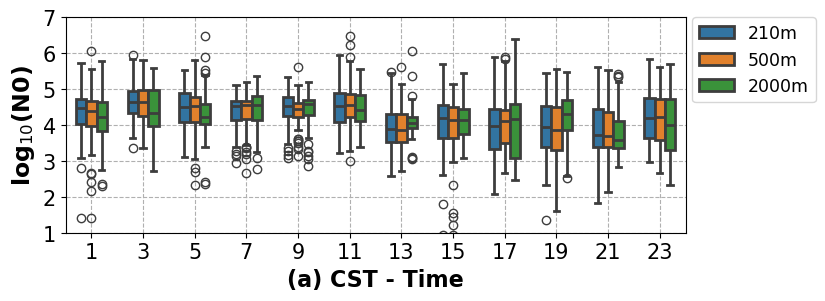

In [388]:
f  = plt.figure(figsize = (8,2.8))
sns.boxplot(x='leibie', y='data',hue="Height", data=df_filtered,width = 0.6,linewidth=2)

plt.grid(True,linestyle = '--')
plt.legend(fontsize = 12.5,  loc='upper right', bbox_to_anchor = (1.21, 1), borderaxespad = 0)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(1,7)
plt.ylabel('log$_{10}$(N0)',size  =17,fontweight='bold')
plt.xlabel('(a) CST - Time',size = 16,fontweight='bold')
plt.savefig('/home/penny/works/psd/results/wok05/7_8_Dm_time_distribution.png',bbox_inches = 'tight')

In [378]:
df = pd.DataFrame(np.zeros((t_list_p.shape[0]*3,3)), columns = ['data','leibie','Height'])
af = pd.DataFrame(np.zeros((t_list_p.shape[0]*3,2)), columns = ['data','leibie'])

data = []
data1 = []
data2 = []
time = []
for i in range(24):
    data += list(retrieved_Dm[time_sel_idx[i],7])
    data1 += list(retrieved_Dm[time_sel_idx[i],17])
    data2 += list(retrieved_Dm[time_sel_idx[i],55])
    time += list(np.repeat(str(i),len(retrieved_Dm[time_sel_idx[i]])))


height = list(np.repeat('210m',len(t_list_p)))+list(np.repeat('500m',len(t_list_p)))+list(np.repeat('2000m',len(t_list_p)))
df['data'] = data+data1+data2
df['leibie'] = time + time+ time
df['Height'] = height                                                                                    



In [383]:
df_filtered = df[(df['leibie'] == str(1)) | (df['leibie'] == str(3)) | (df['leibie'] == str(5)) | (df['leibie'] == str(7)) | (df['leibie'] == str(9)) | (df['leibie'] == str(11)) | (df['leibie'] == str(13)) | (df['leibie'] == str(15)) | (df['leibie'] == str(17)) | (df['leibie'] == str(19)) | (df['leibie'] == str(21)) | (df['leibie'] == str(23))]
df_filtered = df_filtered[df_filtered['data'] != 0]

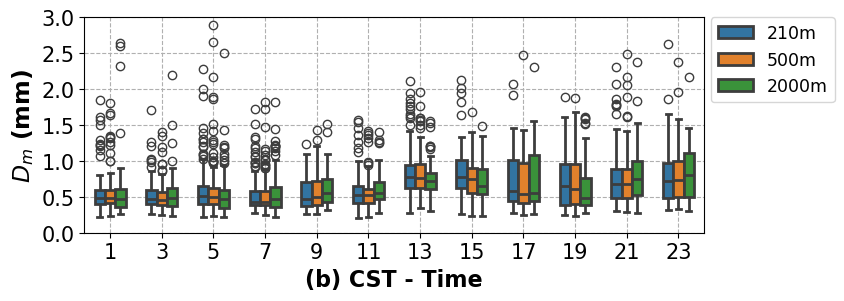

In [384]:
f  = plt.figure(figsize = (8,2.8))
sns.boxplot(x='leibie', y='data',hue="Height", data=df_filtered,width = 0.6,linewidth=2)

plt.grid(True,linestyle = '--')
plt.legend(fontsize = 12.5,  loc='upper right', bbox_to_anchor = (1.21, 1), borderaxespad = 0)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylim(0,3)
plt.ylabel('$D_m$ (mm)',size  =17,fontweight='bold')
plt.xlabel('(b) CST - Time',size = 16,fontweight='bold')
plt.savefig('/home/penny/works/psd/results/wok05/7_8_N0_time_distribution.png',bbox_inches = 'tight')